In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

In [26]:
df = pd.read_csv('money-price-2-time-series.csv', parse_dates=['DATE'],index_col='DATE')
df.rename(columns={'IPG2211A2N': 'Money_price'}, inplace=True)

In [27]:
df

,Money_price
DATE,
1985-01-01,117.288935
1985-02-01,84.458999
1985-03-01,101.121878
1985-04-01,97.620130
1985-05-01,74.422891
...,...
2017-09-01,87.784420
2017-10-01,42.671865
2017-11-01,82.784560


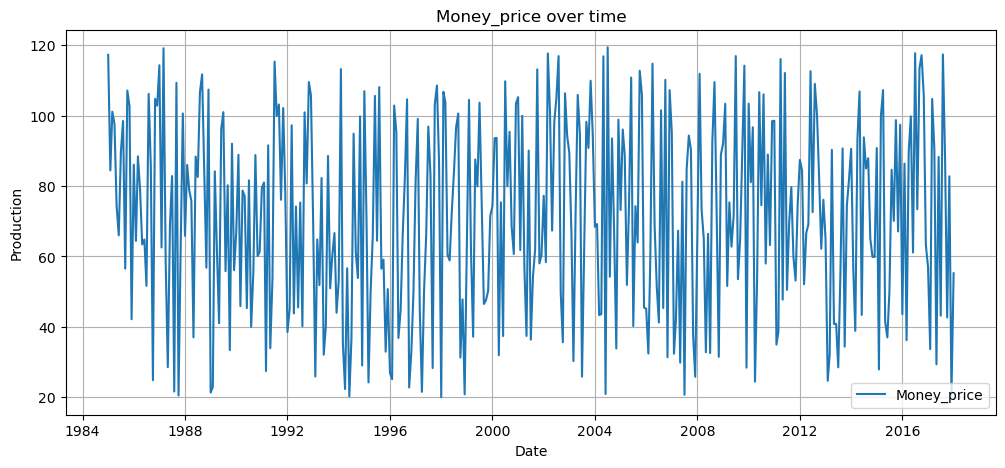

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Money_price'], label='Money_price')
plt.title('Money_price over time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
df['Lag_1'] = df['Money_price'].shift(1)
df['Rolling_Mean_12'] = df['Money_price'].rolling(window=12).mean()
df['Expanding_Mean'] = df['Money_price'].expanding().mean()

In [30]:
def adf_test(df):
    result = adfuller(df)
    print("ADF Statistic:", result[0])
    print("p-values:", result[1])
    if result[1] <= 0.05:
        print("Data is Stationary")
    else:
        print("Data is not Stationary")

In [31]:
adf_test(df['Money_price'])

ADF Statistic: -20.795782866925073
p-values: 0.0
Data is Stationary


In [32]:
df['Money_price_diff'] = df['Money_price'].diff().dropna()
df['Money_price_diff'] = df['Money_price'].diff(12).dropna()

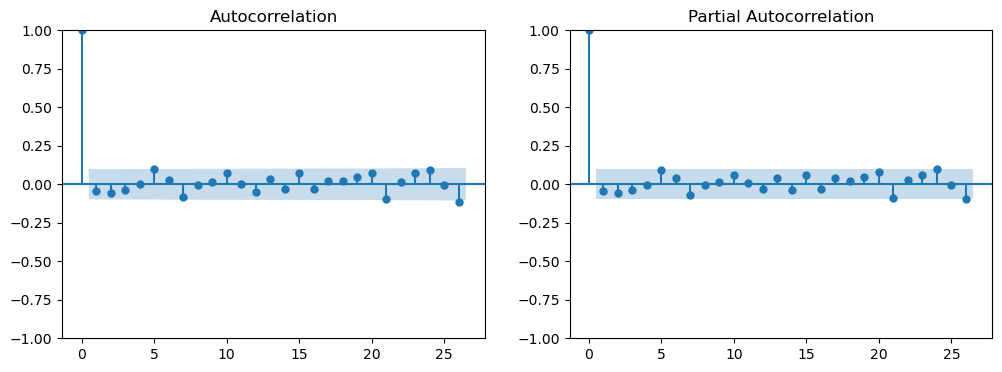

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['Money_price'].dropna(), ax=axes[0])
plot_pacf(df['Money_price'].dropna(), ax=axes[1])
plt.show()

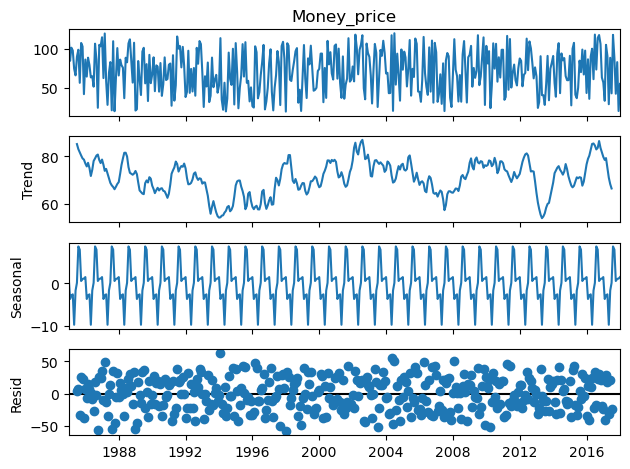

In [34]:
decomposition = seasonal_decompose(df['Money_price'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

In [35]:
df['Diff_1'] = df['Money_price'].diff()
df['Seasonal_Diff_12'] = df['Money_price'].diff(12)

In [36]:
train_size = int(len(df) * 0.8)
train, test = df['Money_price'][0:train_size], df['Money_price'][train_size:]

In [37]:
history = train.tolist()
predictions = []
for t in test:
    model = AutoReg(history, lags = 7)
    model_fit = model.fit()
    
    y_pred = model_fit.predict(start=len(history), end=len(history))[0]
    predictions.append(y_pred)
    
    history.append(t)

In [38]:
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Walk-Forward Validation RMSE: {rmse:.4f}')

Walk-Forward Validation RMSE: 26.5367


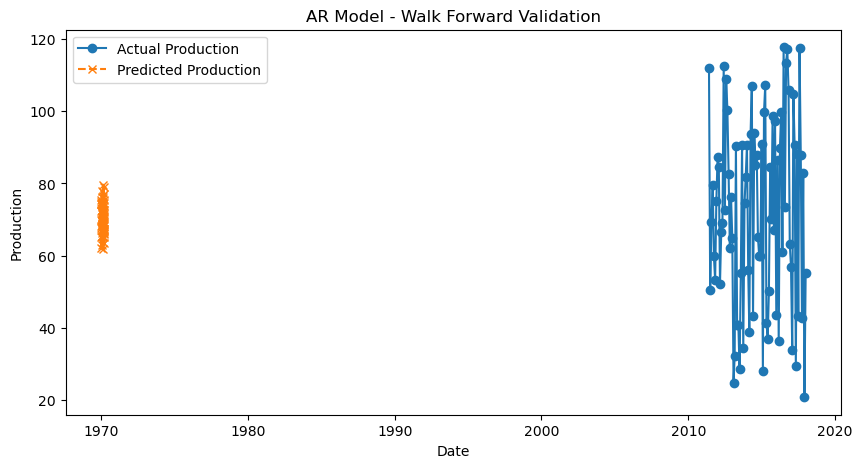

In [39]:
plt.figure(figsize=(10,5))
plt.plot(test, label='Actual Production', marker='o')
plt.plot(predictions, label='Predicted Production', marker='x', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('AR Model - Walk Forward Validation')
plt.legend()
plt.show()

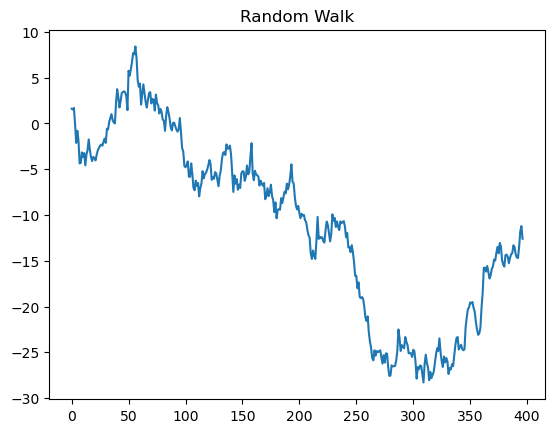

In [40]:
random_walk = np.random.normal(0, 1, len(df)).cumsum()
plt.plot(random_walk)
plt.title('Random Walk')
plt.show()

In [41]:
model_ar = AutoReg(train, lags=12).fit()
predictions = model_ar.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


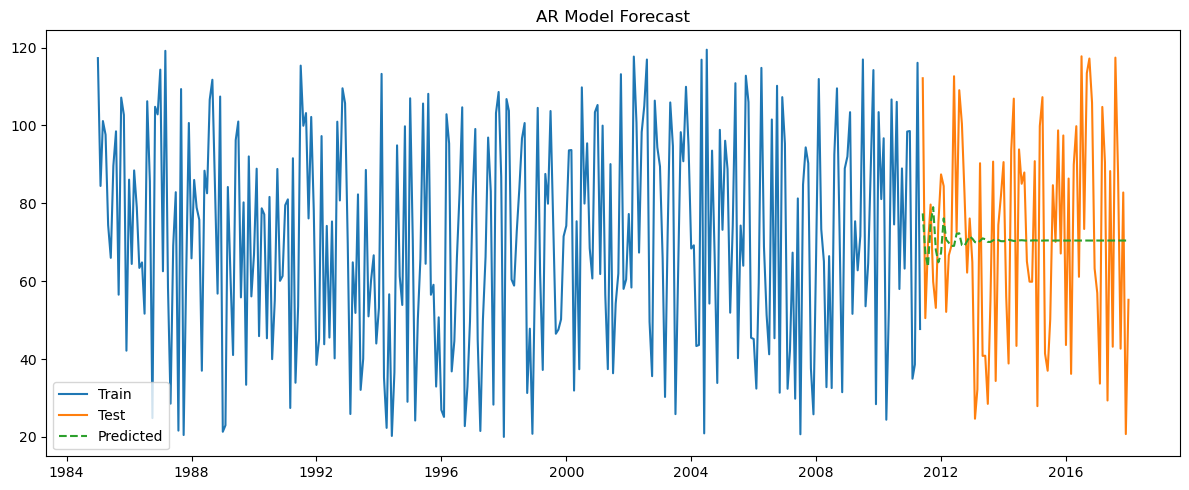

In [42]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Predicted', linestyle='--')
plt.legend()
plt.title('AR Model Forecast')
plt.tight_layout()
plt.show()